## Building out a model

In [503]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier



In [504]:
model_features = pd.read_csv("C:/Users/HP/OneDrive/Documents/DANNY DATA/Customer Support Data/model_data.csv")

In [505]:
columns_to_drop = ["category", "sub-category", "issue_reported_at", "issue_responded", "response_time_(minutes)", 
                   "response_time_(seconds)", "time_of_issue", "time_of_response", "agent_name", "supervisor"]

model_features.drop(columns=columns_to_drop, axis=1, inplace=True)
model_features.head()

,channel_name,response_time_(hours),report_day_name,report_month_day,response_month_day,response_day_name,manager,tenure_bucket,agent_shift,csat_score
0,Outcall,0.566667,Tuesday,1,1,Tuesday,Jennifer Nguyen,On Job Training,Morning,5
1,Outcall,0.033333,Tuesday,1,1,Tuesday,Michael Lee,>90,Morning,5
2,Inbound,0.366667,Tuesday,1,1,Tuesday,William Kim,On Job Training,Evening,5
3,Inbound,0.333333,Tuesday,1,1,Tuesday,John Smith,>90,Evening,5
4,Inbound,0.033333,Tuesday,1,1,Tuesday,Michael Lee,0-30,Morning,5


In [506]:
model_features.columns

Index(['channel_name', 'response_time_(hours)', 'report_day_name',
       'report_month_day', 'response_month_day', 'response_day_name',
       'manager', 'tenure_bucket', 'agent_shift', 'csat_score'],
      dtype='object')

In [507]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder()

In [508]:
scale_features = ["response_time_(hours)", "report_month_day", "response_month_day"]

# one-hot encoding, no inhherent order
model_features = pd.get_dummies(model_features, columns=["channel_name", "manager", "agent_shift", "report_day_name", "response_day_name"])

# Inherent  order is present
model_features["tenure_bucket"] = label_encoder.fit_transform(model_features["tenure_bucket"])

In [509]:
model_features.columns

Index(['response_time_(hours)', 'report_month_day', 'response_month_day',
       'tenure_bucket', 'csat_score', 'channel_name_Email',
       'channel_name_Inbound', 'channel_name_Outcall', 'manager_Emily Chen',
       'manager_Jennifer Nguyen', 'manager_John Smith', 'manager_Michael Lee',
       'manager_Olivia Tan', 'manager_William Kim', 'agent_shift_Afternoon',
       'agent_shift_Evening', 'agent_shift_Morning', 'agent_shift_Night',
       'agent_shift_Split', 'report_day_name_Friday', 'report_day_name_Monday',
       'report_day_name_Saturday', 'report_day_name_Sunday',
       'report_day_name_Thursday', 'report_day_name_Tuesday',
       'report_day_name_Wednesday', 'response_day_name_Friday',
       'response_day_name_Monday', 'response_day_name_Saturday',
       'response_day_name_Sunday', 'response_day_name_Thursday',
       'response_day_name_Tuesday', 'response_day_name_Wednesday'],
      dtype='object')

In [510]:
model_features["csat_binary"] = model_features["csat_score"].apply(lambda x: 1 if x > 3.7 else 0)
model_features.drop(columns=["csat_score"], axis=1, inplace=True)

In [511]:
X = model_features.drop(columns=["csat_binary"], axis=1)
y = model_features["csat_binary"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68725, 32), (17182, 32), (68725,), (17182,))

In [512]:
model = XGBClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.04      0.07      2971
           1       0.83      0.99      0.90     14211

    accuracy                           0.82     17182
   macro avg       0.61      0.51      0.48     17182
weighted avg       0.76      0.82      0.76     17182



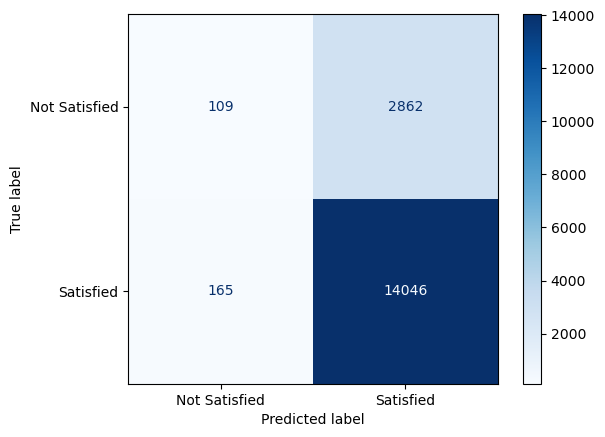

In [513]:
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Not Satisfied", "Satisfied"], cmap="Blues")
plt.show()


In [514]:
from sklearn.utils import resample
majority = model_features[model_features['csat_binary'] == 1]
minority = model_features[model_features['csat_binary'] == 0]

majority_downsampled = resample(majority, replace=False, n_samples=minority.shape[0], random_state=42)
majority_downsampled.shape, minority.shape

((15071, 33), (15071, 33))

In [515]:
balanced_data = pd.concat([majority_downsampled, minority])

# # Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# # Separate features and target variable again
X_balanced = balanced_data.drop(columns=["csat_binary"])
y_balanced = balanced_data["csat_binary"]

In [516]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


In [517]:

model_balanced = XGBClassifier()

grid_search = GridSearchCV(estimator=model_balanced, param_grid={"max_depth": [3, 5, 7], "n_estimators": [50, 100, 150]}, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train_balanced, y_train_balanced)

grid_search.predict(X_test_balanced)

print(f"best parameters: {grid_search.best_params_}, best score: {grid_search.best_score_}")


Fitting 5 folds for each of 9 candidates, totalling 45 fits
best parameters: {'max_depth': 3, 'n_estimators': 100}, best score: 0.6177582737492898


              precision    recall  f1-score   support

           0       0.61      0.60      0.61      2980
           1       0.62      0.63      0.63      3049

    accuracy                           0.62      6029
   macro avg       0.62      0.62      0.62      6029
weighted avg       0.62      0.62      0.62      6029



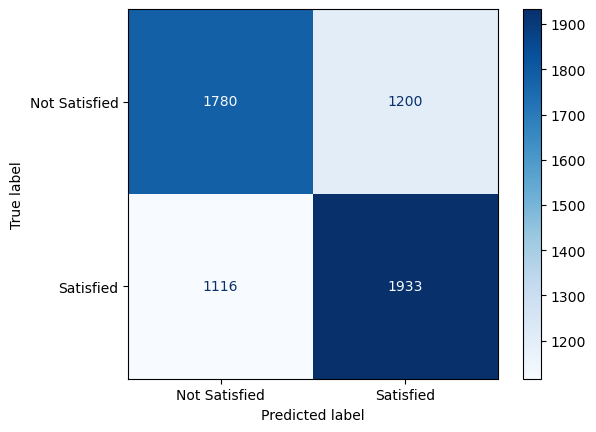

In [518]:

print(classification_report(y_test_balanced, grid_search.predict(X_test_balanced)))

ConfusionMatrixDisplay.from_estimator(grid_search, X_test_balanced, y_test_balanced, display_labels=["Not Satisfied", "Satisfied"], cmap="Blues")
